## **Viral vs Bacterial Pneumonia Image Classification using Transfer Learning**

**Dataset:** Chest X-Ray Images (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

The original problem statement is to classify normal Chest X -rays and Pneumonia Chest X-rays. The pneumonia images contain both bacterial and viral pneumonia images.

***To make the problem more challenging, the normal images were removed and the pnenumina images alone were used to build a binary classifier than can distinguish between Viral and Bacterial Pnenumonia.***





In [1]:
# Import the necessary packages 
import os
import numpy as np
import pandas as pd
import random
import cv2
import seaborn as sns
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import argparse
import imutils
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The images are stored in Google Drive. We connect the notebook to Goggle Drive first to access the image files.




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Dataset directory in Drive
train_data_path = '/content/drive/My Drive/Chest_X_rays/Train'
test_data_path = '/content/drive/My Drive/Chest_X_rays/Test'

In [ ]:
# Get few samples for both the classes
bacteria_cases_dir = os.path.join(train_data_path,'Bacteria')
virus_cases_dir = os.path.join(train_data_path,'Virus')

# Get the list of all the images
bacteria_cases = glob(bacteria_cases_dir + '/*.jpeg') 
virus_cases = glob(virus_cases_dir + '/*.jpeg')

# An empty list
samples = []

# Go through all the normal cases. The label for these cases will be 0
for i in range(5):
    samples.append(bacteria_cases[i])

# Go through all the pneumonia cases. The label for these cases will be 1
for i in range(5):
    samples.append(virus_cases[i])

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Bacteria")
    else:
        ax[i//5, i%5].set_title("Virus")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

#**Image Data Augmentation**

**ImageDataGenerator** is used to dynamically augment the images while passing the data in batches during training. 

After augmentation, the **preprocessing_function** will pre-process the inputs based on the pre-trained dataset. **10% of training data is used as validation.**

For each image in the training set, the image is augmented with random horizontal flipping and zoom before being fed into the network. The augmentation is not applied for testing set.

 All the above steps can be applied to the images dynamically using the ImageDataGenerator class and then flow_from_directory or flow_from_dataframe methods in Keras. The ImageDataGenerator class consists of lot of different options for augmenting the data. Refer to https://keras.io/api/preprocessing/image/#imagedatagenerator-class to know more. The below parameters were used in this case: 
 * <b>zoom_range:</b> 0.1 
 * <b>fill_mode:</b> ‘constant’ 
 * <b>horizontal_flip:</b> True 
 * <b>preprocessing_function:</b> preprocess_input 
 * <b>validation_split:</b> 0.1 (Use 10% of training data for validation) 




 


In [ ]:
# Data generation objects
train_datagen = ImageDataGenerator(zoom_range=0.1,     
                                   horizontal_flip = True,
                                   fill_mode = 'constant',
                                   validation_split=0.1,
                                   preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

The ***flow_from_directory*** function takes the path to a directory & generates batches of augmented data. Refer to https://keras.io/api/preprocessing/image/#flowfromdirectory-method to know more.

The images are re-sized to 224 x 224 which is the input shape for DenseNet121.

Batch size is set to 32, class mode is binary since it is binary classification and the data is randomy shuffled.

In [ ]:
image_size = 224
batch_size = 32

# This is fed to the network in the specified batch sizes and image dimensions
train_gen = train_datagen.flow_from_directory(train_data_path, 
                                              target_size=(image_size, image_size), 
                                              batch_size=batch_size, 
                                              class_mode='binary', 
                                              shuffle=True,
                                              subset='training')

val_gen = train_datagen.flow_from_directory(train_data_path, # same directory as training data
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  shuffle = True,
                                                  class_mode='binary',
                                                  subset='validation')

test_gen = test_datagen.flow_from_directory(test_data_path, 
                                                target_size=(image_size, image_size), 
                                                batch_size=batch_size, 
                                                class_mode='binary', 
                                                shuffle=True)

Found 3496 images belonging to 2 classes.
Found 387 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


# **Handling Class Imbalance using Weighted Loss Function**

The dataset is imbalanced as the number of bacterial pneumonia images is quite high than the number of virus pneumonia images. Class imbalance represents an important problem for intelligent classification algorithms.

The goal is to identify bacterial/viral pneumonia, but we don't have very many of those virus pneumonia samples (positive samples to work with) and so we would want to have the classifier heavily weight the few examples that are available. **This will cause the model to "pay more attention" to examples from an under-represented class.**

In Keras, this can be done by passing Keras weights for each class through a parameter class weight in model fit method.

In [ ]:
#Compute class weights for handling the imbalance in data

bacteria_pneumonia_dir = os.path.join(train_data_path, 'Bacteria') 
virus_pneumonia_dir = os.path.join(train_data_path, 'Virus') 

bacteria_cases = glob(bacteria_pneumonia_dir + '/*.jpeg') 
virus_cases = glob(virus_pneumonia_dir + '/*.jpeg')

train_labels = []

for img_path in bacteria_cases:
  train_labels.append(0)

for img_path in virus_cases:
  train_labels.append(1)

#convert label list to numpy array
train_labels = np.array(train_labels)

#Compute class weights for each class
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels),
                                                 train_labels)
print(class_weights)

[0.76497242 1.44349442]


# **Transfer Learning using DenseNet121**


The model used is a ***121-layer Dense Convolutional Network (DenseNet)*** trained on the ImageNet dataset. Use the pre-trained DenseNet121 model and add a ***Pooling layer, dropout layer*** and finally, a **dense layer with Sigmoid activation** for making the predictions.

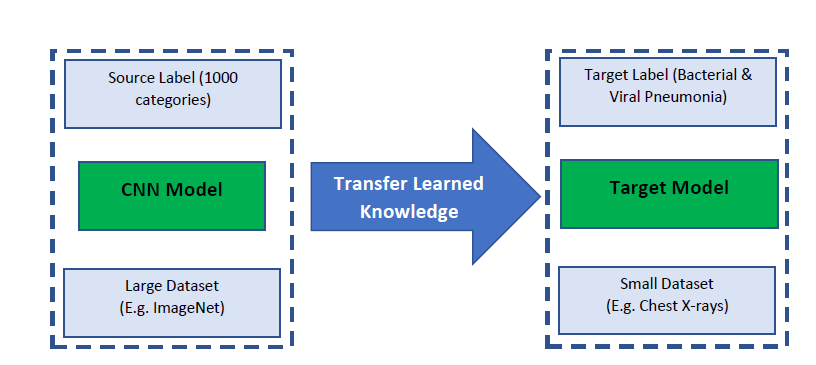




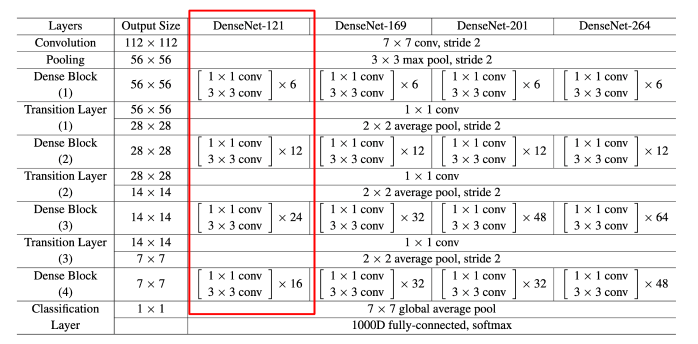


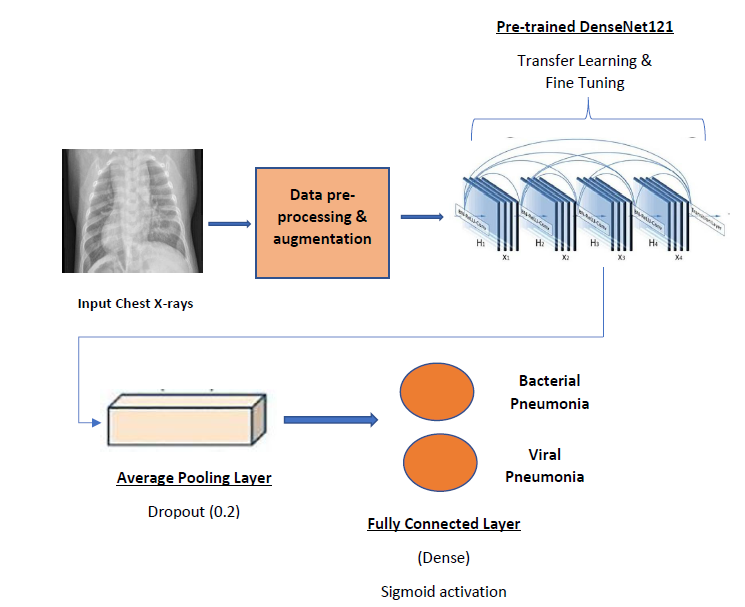

In [4]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

#Dropout Layer
x = Dropout(0.2)(x) # Regularize with dropout

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

29089792/29084464 [==============================] - 0s 0us/step


# **Freeze the convolutional base**

It is important to freeze the convolutional base before you compile and train the model. In Keras, freezing ***(by setting layer.trainable = False)*** prevents the weights in each layer from being updated during training. DenseNet121 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

We train the model for few epochs initially. All the layers of the base model are not trainable and only the newly added classification layers are trained in this phase.

In [ ]:
# don't train existing weights
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
#Check the model summary and trainable parameters
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

**Optimizer:** We use Adam optimizer and we initialise the learning rate with 0.0001 which is commonly used in various transfer learning approaches.

**Loss:** We use binary cross-entropy since it is a binary classification task.

**ReduceLRonPlateau:** Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. Refer to https://keras.io/api/callbacks/reduce_lr_on_plateau/ to know more.

The parameter settings used are as follows: 
* ***monitor:*** ‘val_loss’ (Validation loss) 
* ***factor:*** 0.1 
* ***patience:*** 1 
* ***verbose:*** 1

**EarlyStopping:** Stop training when a monitored metric has stopped improving. Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. Once it's found no longer decreasing, the training terminates. Refer to https://keras.io/api/callbacks/early_stopping/ to know more.

The parameter settings used are as follows: 
monitor: ‘val_loss’
* ***min_delta:*** 0.0001
* ***patience:*** 2
* ***verbose:*** 1
* ***mode:*** ‘min’ 

ModelCheckpoint: Callback to save the Keras model or model weights at some frequency. It is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved. Refer to https://keras.io/api/callbacks/model_checkpoint/ to know more.

The parameter settings used are as follows: 
* ***filepath:*** the path and filename to save 
* ***monitor:*** ‘val_loss’ 
* ***verbose:*** 1 
* ***save_best_only:*** True 
* ***save_weights_only:*** True

In [ ]:
#Follow ChexNeXt Paper
base_learning_rate = 0.0001

#Compile model
model.compile(optimizer=Adam(lr= base_learning_rate), loss= "binary_crossentropy", metrics = ['accuracy'])

We first train the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

We **save the best model** in the process based on validation loss.

The **learning rate** is reduced by a factor of 10 when the validation loss does not improve for an epoch.

**Early stopping**  is used to stop thr training in between if validation loss does not improve.

In [ ]:
#epochs
initial_epochs = 20

# Callbacks
#Save best model
ckpt_filename= "/content/drive/My Drive/Chest_X_rays/dn121_class_weights_pretrained.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='min', verbose = 1)

**Assign the class weights** to the model using the *class_weight* parameter in model.fit() method.

In [ ]:
# Fitting the model
history = model.fit(train_gen,
                    epochs=initial_epochs,
                    validation_data=val_gen,
                    callbacks=[checkpoint, early_stop, lr_reduce], 
                    class_weight = {0: class_weights[0], 1: class_weights[1]})

Epoch 1/20
110/110 [==============================] - ETA: 0s - loss: 1.8664 - accuracy: 0.4777 
Epoch 00001: val_loss improved from inf to 1.12230, saving model to /content/drive/My Drive/Chest_X_rays/dn121_class_weights_pretrained.hdf5
110/110 [==============================] - 1261s 11s/step - loss: 1.8664 - accuracy: 0.4777 - val_loss: 1.1223 - val_accuracy: 0.4703
Epoch 2/20
110/110 [==============================] - ETA: 0s - loss: 1.5112 - accuracy: 0.4971
Epoch 00002: val_loss improved from 1.12230 to 0.83965, saving model to /content/drive/My Drive/Chest_X_rays/dn121_class_weights_pretrained.hdf5
110/110 [==============================] - 67s 609ms/step - loss: 1.5112 - accuracy: 0.4971 - val_loss: 0.8396 - val_accuracy: 0.5530
Epoch 3/20
110/110 [==============================] - ETA: 0s - loss: 1.4190 - accuracy: 0.5255
Epoch 00003: val_loss improved from 0.83965 to 0.66106, saving model to /content/drive/My Drive/Chest_X_rays/dn121_class_weights_pretrained.hdf5
110/110 [===

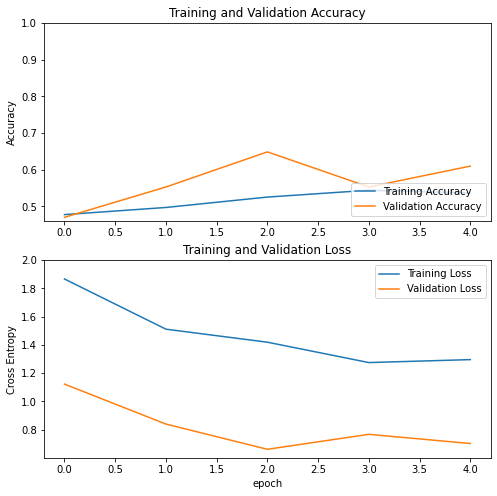

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In some cases, the validation metrics are clearly better than the training metrics, the main factor is because layers like ***tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout*** affect accuracy during training. They are turned off when calculating validation loss.

In [ ]:
#Load the best model during initial training
model.load_weights(ckpt_filename)

# **Fine-Tuning**

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

***Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.*** 

In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [ ]:
#Finetuning - Unfreeze the last layers of the model
base_model.trainable = True

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

Compile the models.As you are training a much larger model and want to readapt the pretrained weights, **it is important to use a lower learning rate at this stage**. Otherwise, your model could overfit very quickly.

In [ ]:
#compile model
model.compile(optimizer= Adam(lr=base_learning_rate/10), loss= "binary_crossentropy", metrics = ['accuracy'])

# Callbacks
final_ckpt_filename= "/content/drive/My Drive/Chest_X_rays/dn121_class_weights_best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=final_ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='min', verbose = 1)

In [ ]:
fine_tune_epochs = 20

# Fitting the model
history_unfreeze = model.fit(train_gen,
                    epochs= fine_tune_epochs,
                    validation_data=val_gen,
                    callbacks=[checkpoint, early_stop, lr_reduce],
                    class_weight = {0: class_weights[0], 1: class_weights[1]})

Epoch 1/20
110/110 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.6828
Epoch 00001: val_loss improved from inf to 0.49130, saving model to /content/drive/My Drive/Chest_X_rays/dn121_class_weights_best_model.hdf5
110/110 [==============================] - 81s 733ms/step - loss: 0.6643 - accuracy: 0.6828 - val_loss: 0.4913 - val_accuracy: 0.8088
Epoch 2/20
110/110 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.7137
Epoch 00002: val_loss improved from 0.49130 to 0.42239, saving model to /content/drive/My Drive/Chest_X_rays/dn121_class_weights_best_model.hdf5
110/110 [==============================] - 79s 715ms/step - loss: 0.5904 - accuracy: 0.7137 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 3/20
110/110 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.7317
Epoch 00003: val_loss improved from 0.42239 to 0.36971, saving model to /content/drive/My Drive/Chest_X_rays/dn121_class_weights_best_model.hdf5
110/110 [====

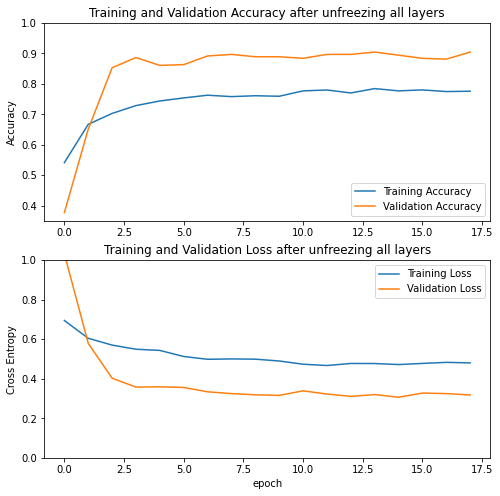

In [ ]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy after unfreezing all layers')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss after unfreezing all layers')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Load the best model
model.load_weights(final_ckpt_filename)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
#Evaluate on the test data
test_loss, test_score = model.evaluate(test_gen)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

13/13 [==============================] - 114s 9s/step - loss: 0.3166 - accuracy: 0.9026
Loss on test set:  0.31659531593322754
Accuracy on test set:  0.9025641083717346


The below function is used to pre-process the images in test data and evaluate the model on the test set. It does the following:


*   Resize the images based on pre-trained model
*   Normalize the images on the pre-trained dataset



In [7]:
def fn_preprocess_images(data_directory, image_size):
  bacteria_pneumonia_dir = os.path.join(data_directory, 'Bacteria') 
  virus_pneumonia_dir = os.path.join(data_directory, 'Virus') 

  # Get the list of all the images
  bacteria_cases = glob(bacteria_pneumonia_dir + '/*.jpeg') 
  virus_cases = glob(virus_pneumonia_dir + '/*.jpeg')

  #Store all images and labels
  image_data_list = []
  labels = []
  
  for img_path in bacteria_cases:
    img = image.load_img(img_path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #print('Input image shape:', x.shape)
    image_data_list.append(x)
    labels.append(0)

  for img_path in virus_cases:
    img = image.load_img(img_path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #print('Input image shape:', x.shape)
    image_data_list.append(x)
    labels.append(1)
 
  #Convert the images to tensor shape (n_images, h, w, channel)
  img_data = np.array(image_data_list)
  img_data=np.rollaxis(img_data,1,0)
  img_data=img_data[0]
  print("Final data shape: "+str(img_data.shape))

  #convert label list to numpy array
  labels = np.array(labels)

  return img_data,labels

In [ ]:
test_data, test_labels  = fn_preprocess_images(test_data_path, image_size = 224)

In [ ]:
#Predict on test data
preds = model.predict(test_data)

In [ ]:
# Classification report 
from sklearn.metrics import accuracy_score,classification_report, roc_curve, confusion_matrix

acc = accuracy_score(test_labels, np.round(preds))*100
print("Test data accuracy : "+str(acc))
print("Classification report")
print(classification_report(test_labels,np.round(preds)))

Test data accuracy : 90.25641025641026
Classification report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       242
           1       0.89      0.85      0.87       148

    accuracy                           0.90       390
   macro avg       0.90      0.89      0.90       390
weighted avg       0.90      0.90      0.90       390



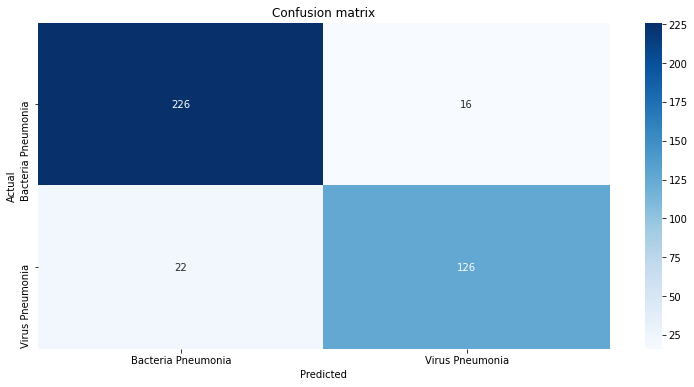

In [ ]:
#Plot the confusion matrix
conf_matrix = confusion_matrix(test_labels, np.round(preds))
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=['Bacteria Pneumonia', 'Virus Pneumonia'], 
            yticklabels=['Bacteria Pneumonia', 'Virus Pneumonia'],
            cmap="Blues",
            fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

# **ROC Curve**

In [ ]:
from sklearn.metrics import roc_curve, auc
y_preds = preds.ravel()
model_fpr, model_tpr, model_threshold = roc_curve(test_labels, y_preds)
model_auc = auc(model_fpr, model_tpr)

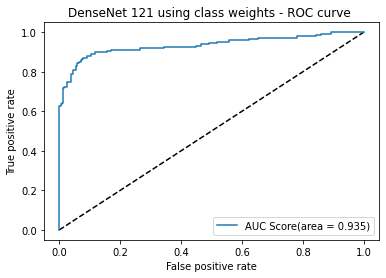

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(model_fpr, model_tpr, label='AUC Score(area = {:.3f})'.format(model_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('DenseNet 121 using class weights - ROC curve ')
plt.legend(loc='best')
plt.show()

# **Model Interpretability using Grad-CAM**

As a deep learning practitioner, one is responsible to ensure the model is performing correctly. One way you can do that is to debug your model and visually validate that it is “looking” and “activating” at the correct locations in an image.

To help deep learning practitioners debug their networks, Selvaraju et al. published a novel paper entitled, Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization.
This method is:
* Easily implemented
* Works with nearly any Convolutional Neural Network architecture
* Can be used to visually debug where a network is looking in an image

***Gradient-weighted Class Activation Mapping (Grad-CAM)*** works by 
**(1) finding the final convolutional layer in the network and then (2) examining the gradient information flowing into that layer.**

***The output of Grad-CAM is a heatmap visualization for a given class label (either the top, predicted label or an arbitrary label we select for debugging). We can use this heatmap to visually verify where in the image the CNN is looking.***

For more information on how Grad-CAM works, refer to Selvaraju et al.’s paper - https://arxiv.org/abs/1610.02391 as well as this article by Divyanshu Mishra - https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48

In [6]:
#Get all the images
test_data_path = '/content/drive/My Drive/Chest_X_rays/Test'
# Get few samples for both the classes
bacteria_cases_dir = os.path.join(test_data_path,'Bacteria/')
virus_cases_dir = os.path.join(test_data_path,'Virus/')

# Get the list of all the images
bacteria_cases = glob(bacteria_cases_dir + '*.jpeg') 
virus_cases = glob(virus_cases_dir + '*.jpeg')

samples = []

# Go through all the bacteria cases. The label for these cases will be 0
for i in bacteria_cases:
    samples.append(i)

# Go through all the virus cases. The label for these cases will be 1
for i in virus_cases:
    samples.append(i)

In [4]:
import sys,os
sys.path.insert(1, "/content/drive/My Drive/Chest_X_rays/gradcam_function")

#GradCAM functions
from compute_gradcam.gradcam import GradCAM 
from gradcam_keras import fn_gradcam 

***fn_gradcam*** takes an image as an input and computes the GradCAM using the trained model. It finally prints three images stacked vertically.

1. Original image
2. Heatmap generated using the last convulational layer activations
3. Heatmap superimposed on the image (The predicted image class and probability is also included)

Image name: person113_bacteria_543.jpeg


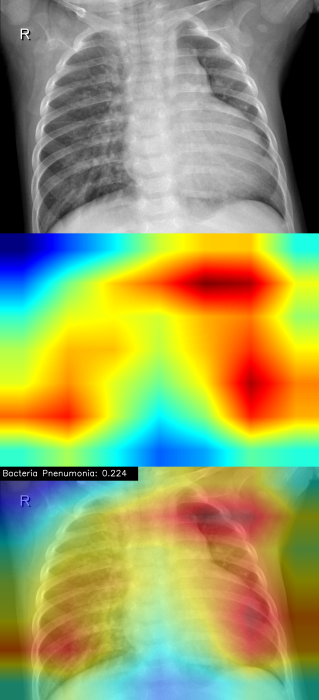

In [23]:
fn_gradcam(samples[10])

Image name: person101_bacteria_485.jpeg


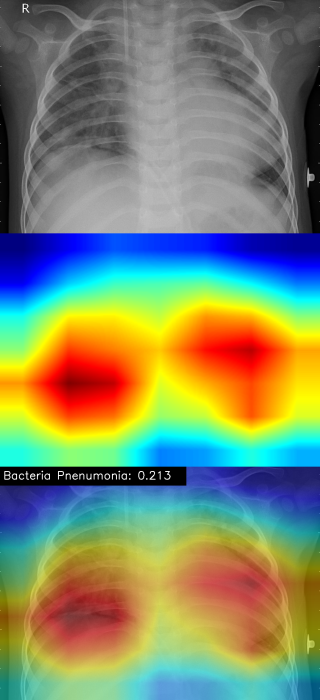

In [24]:
fn_gradcam(samples[12])

Image name: person1618_virus_2805.jpeg


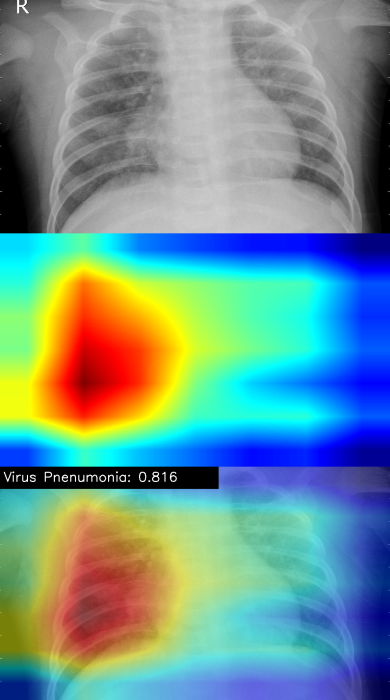

In [25]:
fn_gradcam(samples[247])

Image name: person1613_virus_2799.jpeg


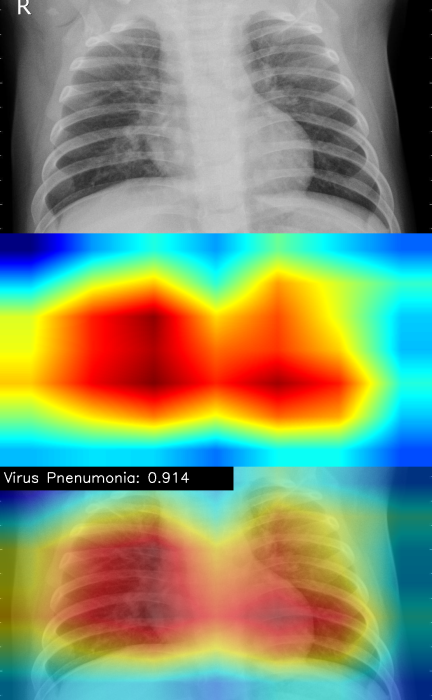

In [26]:
fn_gradcam(samples[249])

Image name: person1615_virus_2801.jpeg


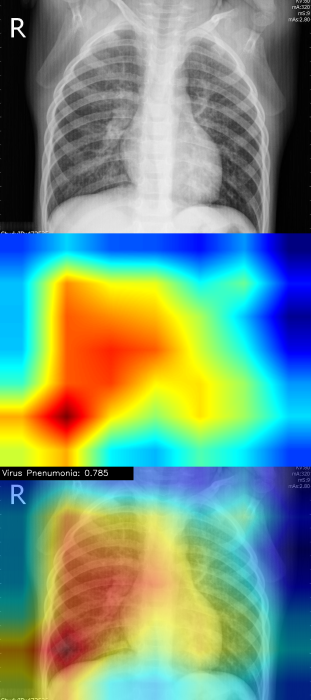

In [27]:
fn_gradcam(samples[250])